# Artist Identification

### TODO

* Work more on the visualization of results

In [1]:
# Plotting
from matplotlib.colors import ListedColormap

# Preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import multilabel_confusion_matrix
import time

# Classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel


# Dimensionality reduction libraries
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn import manifold, datasets, decomposition, discriminant_analysis

#Other libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pickle
from joblib import dump, load
import json
import os

#Load DIP modules
import glob
import dippykit as dip

In [2]:
%matplotlib inline

# Feature Extraction

### Importing extracted and saved features

In [3]:
import pickle

hu_moments_list_tuple = pd.read_pickle( "Feature Extraction/Hu Moments.pkl") 
histograms_list_tuple = pd.read_pickle( "Feature Extraction/Color Histograms.pkl" ) 
hog_list_tuple = pd.read_pickle( "Feature Extraction/HOGs Resized.pkl") 
lbp_list_tuple = pd.read_pickle( "Feature Extraction/Resized_LPBs.pkl" ) 
sift_list_tuple = pd.read_pickle( "Feature Extraction/SIFTs.pkl" ) 


### Converting artist names to labels

In [4]:
type([x[1] for x in histograms_list_tuple])
names = [x[1] for x in histograms_list_tuple]
d = {ni: indi for indi, ni in enumerate(set(names))}
y = np.array([d[ni] for ni in names])
print("Training set details:")
print("Artist-label map:", d)
print("Total number of images:",y.shape[0])
print("Diego:",y[y==0].shape[0])
print("Rembrandt:",y[y==1].shape[0])
print("Caravaggio:",y[y==2].shape[0])
print("Peter:",y[y==3].shape[0])

Training set details:
Artist-label map: {'Diego': 0, 'Rembrandt': 1, 'Peter': 2, 'Caravaggio': 3}
Total number of images: 586
Diego: 128
Rembrandt: 262
Caravaggio: 141
Peter: 55


In [5]:
hu_moments = np.squeeze(np.array([x[2] for x in hu_moments_list_tuple]))
histograms = np.reshape(np.squeeze(np.array([x[2] for x in histograms_list_tuple])),(len(hu_moments_list_tuple),-1))
hog = np.squeeze(np.array([x[2] for x in hog_list_tuple]))
lbp = np.reshape(np.squeeze(np.array([x[2] for x in lbp_list_tuple])),(len(hu_moments_list_tuple),-1))
sift = np.squeeze([i[:20,:] for i in [x[2] for x in sift_list_tuple]]).reshape(586,2560)

# Feature dimensions
print("(Number of images, Number of features)")
print("Hu Moments:",hu_moments.shape)
print("Histograms:",histograms.shape)
print("HoG:",hog.shape)
# print("LBP:",lbp.shape)
print("SIFT:",sift.shape)

(Number of images, Number of features)
Hu Moments: (586, 7)
Histograms: (586, 768)
HoG: (586, 3600)
SIFT: (586, 2560)


In [6]:
datasets = [(hu_moments,y), (histograms,y), (hog,y),(sift,y)]
# datasets = [(hu_moments,y)]

In [7]:
y.shape


(586,)

# Dimensionality reduction

In [8]:
# Dimensionality reduction algorithms
dr_names = ["kpca","lda","tsne"]

In [9]:
# Apply dimensionality reduction to the dataset

def dim_red(X, y, best_params):
#     {'reduce_dim': KernelPCA(kernel='rbf', n_components=4), 'reduce_dim__kernel': 'rbf', 'reduce_dim__n_components': 4}
    dr = best_params['reduce_dim']
    
    X_dr = dr.fit_transform(X, y)
    
    return X_dr

# GridSearchCV

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin #gives fit_transform method for free
#Since TSNE does not have a transform method
class tSNE(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.model = TSNE(n_components)
    
    def fit(self, X, y=None):
#         self.model.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.model.fit_transform(X)

In [11]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

def tune_clf(X_train, y_train, parameters, num_fold, clf_name):
    
    # Define the pipeline
    pipe = Pipeline([
        ('reduce_dim', KernelPCA()),
        ('classify', KNeighborsClassifier(3))
    ])

    # Use kFold CV for evaluating the pipeline
    kf = KFold(n_splits = num_fold, shuffle = False)
    
    # Define the paramters to search over for dimensionality reduction
    
    # Change N_FEATURES_OPTIONS for different types of features
    num_feat = X_train.shape[1]
    N_FEATURES_TSNE = [2, 3]
    if num_feat < 8:
        N_FEATURES_OPTIONS = [2, 4, 6]
    else:
        # It does not make sense to have the number of prinicpal features to be more than the number of samples in the dataset 
        N_FEATURES_OPTIONS = [10, 100, 200]
        
   
    KERNELS = ['linear', 'rbf', 'poly']
    
    # Define the parameters to search over for the classifiers
    #KNN
    N_NEIGHBORS = [2, 3, 4, 5, 6, 7, 8]
    #SVM
    CS = [0.025, 0.05, 0.1, 1]
    GAMMAS = [0.1, 1, 10]
    #Gaussian Process
    KERNELS_GP = [1.0 *RBF(1.0), DotProduct(), WhiteKernel(noise_level=0.5), DotProduct() + WhiteKernel(noise_level=0.5)]
    #Decision Tree
    CRITERIA = ['gini', 'entropy']
    SPLITTERS = ['best', 'random']
    MAX_DEPTHS = [5, 10, 15]
    #MLP
    ALPHAS = [0.001, 0.01, 0.1, 1.0]
    LAYERS = [(100,20,10), (100,50,20), (100,100,20)]
    #AdaBoost
    LEARNING_RATES = [0.01, 0.1, 1.0]    
    
    param_grid = [
            {
                'reduce_dim': [KernelPCA()],
                'reduce_dim__n_components': N_FEATURES_OPTIONS,
                'reduce_dim__kernel': KERNELS
            },
            {
                'reduce_dim': [LinearDiscriminantAnalysis(n_components=3)],
            },
            {
                'reduce_dim': [tSNE()],
                'reduce_dim__n_components': N_FEATURES_TSNE,
            },
        ]
    
    for i in range(3):
        if clf_name == "Nearest Neighbors":
            param_grid[i]['classify'] = [KNeighborsClassifier()]
            param_grid[i]['classify__n_neighbors'] = N_NEIGHBORS
            
        if clf_name == "Logistic Regression":
            param_grid[i]['classify'] = [LogisticRegression(max_iter = 10000)]
        
        if clf_name == "SVM":
            param_grid[i]['classify'] = [SVC(max_iter = 100000)]
            param_grid[i]['classify__kernel'] = KERNELS
            param_grid[i]['classify__C'] = CS
            param_grid[i]['classify__gamma'] = GAMMAS
        
        if clf_name == "Gaussian Process":
            param_grid[i]['classify'] = [GaussianProcessClassifier()]
#             param_grid[i]['classify__kernel'] = KERNELS_GP
            
        if clf_name == "Decision Tree":
            param_grid[i]['classify'] = [DecisionTreeClassifier()]
            param_grid[i]['classify__criterion'] = CRITERIA
            param_grid[i]['classify__splitter'] = SPLITTERS
            param_grid[i]['classify__max_depth'] = MAX_DEPTHS
            
        if clf_name == "Random Forest":
            param_grid[i]['classify'] = [RandomForestClassifier()]
            param_grid[i]['classify__criterion'] = CRITERIA
            param_grid[i]['classify__max_depth'] = MAX_DEPTHS
            
        if clf_name == "Neural Net":
            param_grid[i]['classify'] = [MLPClassifier()]
            param_grid[i]['classify__alpha'] = ALPHAS
            param_grid[i]['classify__hidden_layer_sizes'] = LAYERS
            
        if clf_name == "AdaBoost":
            param_grid[i]['classify'] = [AdaBoostClassifier()]
            param_grid[i]['classify__learning_rate'] = LEARNING_RATES
            
        if clf_name == "Naive Bayes":
            param_grid[i]['classify'] = [GaussianNB()]
            
        if clf_name == "QDA":
            param_grid[i]['classify'] = [QuadraticDiscriminantAnalysis()]

#     grid = GridSearchCV(pipe, cv=kf, n_jobs=6, param_grid=param_grid, scoring='accuracy')
    grid = RandomizedSearchCV(pipe, cv=kf, n_jobs=6, param_distributions=param_grid, scoring='accuracy')
    grid.fit(X_train, y_train)

    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    acc = np.max(mean_scores)
#     print(acc)
    best_params = grid.best_params_
    return best_params

# Classifiers

In [12]:
classifier_names = [
        # "Perceptron",
        "Nearest Neighbors", 
       "Logistic Regression",
        "SVM", 
        #"RBF SVM", 
        "Gaussian Process",
        "Decision Tree", 
        "Random Forest", 
        "Neural Net",
        "AdaBoost",
        "Naive Bayes", 
        "QDA"]

In [13]:
classifiers = [
    #Perceptron(tol=1e-3, random_state=0),
    KNeighborsClassifier(3),
   LogisticRegression(max_iter = 10000),
    SVC(kernel="linear", C=0.025),
  #  SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [14]:
len(classifier_names)

10

**Metrics**

In [15]:
def calculate_precision_recall_f1score_support(y_pred,y_true):
    return precision_recall_fscore_support(y_true, y_pred, average=None)

Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 4, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=4), 'classify__n_neighbors': 8, 'classify': KNeighborsClassifier(n_neighbors=8)}
Train data shape  (351, 4)
Test data shape (235, 4)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (351, 3)
Test data shape (235, 3)
Working on  SVM
Loading from the existing file
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=6), 'classify__kernel': 'poly', 'classify__gamma': 10, 'classify__C': 1, 'classify': SVC(C=1, gamma=10, kernel='poly')}
Train data shape  (351, 6)
Test data shape (235, 6)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Gaussian Process
Loading from the existing file
{'reduce_dim__n_components': 4, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=4), 'classify__kernel': DotProduct(sigma_0=1), 'classify': GaussianProcessClassifier(kernel=DotProduct(sigma_0=1))}
Train data shape  (351, 4)
Test data shape (235, 4)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=6), 'classify__splitter': 'best', 'classify__max_depth': 5, 'classify__criterion': 'entropy', 'classify': DecisionTreeClassifier(criterion='entropy', max_depth=5)}
Train data shape  (351, 6)
Test data shape (235, 6)
Working on  Random Forest
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify__max_depth': 5, 'classify__criterion': 'entropy', 'classify': RandomForestClassifier(criterion='entropy', max_depth=5)}
Train data shape  (351, 3)
Test data shape (235, 3)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Neural Net
Loading from the existing file
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=6), 'classify__hidden_layer_sizes': (100, 50, 20), 'classify__alpha': 0.001, 'classify': MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 50, 20))}
Train data shape  (351, 6)
Test data shape (235, 6)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=6), 'classify__learning_rate': 0.01, 'classify': AdaBoostClassifier(learning_rate=0.01)}
Train data shape  (351, 6)
Test data shape (235, 6)
Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 2, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=2), 'classify': GaussianNB()}
Train data shape 

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 (351, 2)
Test data shape (235, 2)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 2, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=2), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (351, 2)
Test data shape (235, 2)
Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=200), 'classify__n_neighbors': 6, 'classify': KNeighborsClassifier(n_neighbors=6)}
Train data shape  (351, 200)
Test data shape (235, 200)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=200), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (351, 200)
Test data shape (235, 200)
Working on  SVM
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel'

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=10), 'classify__learning_rate': 0.1, 'classify': AdaBoostClassifier(learning_rate=0.1)}
Train data shape  (351, 10)
Test data shape (235, 10)
Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': GaussianNB()}
Train data shape  (351, 10)
Test data shape (235, 10)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (351, 10)
Test data shape (235, 10)
Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'cla

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=100), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (351, 100)
Test data shape (235, 100)
Working on  SVM
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__kernel': 'linear', 'classify__gamma': 1, 'classify__C': 1, 'classify': SVC(C=1, gamma=1, kernel='linear', max_iter=100000)}
Train data shape  (351, 100)
Test data shape (235, 100)
Working on  Gaussian Process
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': GaussianProcessClassifier()}
Train data shape  (351, 3)
Test data shape (235, 3)
Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__splitte

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=100), 'classify__learning_rate': 0.01, 'classify': AdaBoostClassifier(learning_rate=0.01)}
Train data shape  (351, 100)
Test data shape (235, 100)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify': GaussianNB()}
Train data shape  (351, 10)
Test data shape (235, 10)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (351, 10)
Test data shape (235, 10)
Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify__n_neighbors': 5, 'classify': KNeighborsClassifier()}
Train data shape  (351, 3)
Test data shape (235, 3)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=100), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (351, 1

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Gaussian Process
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': GaussianProcessClassifier()}
Train data shape  (351, 10)
Test data shape (235, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__splitter': 'random', 'classify__max_depth': 5, 'classify__criterion': 'gini', 'classify': DecisionTreeClassifier(max_depth=5, splitter='random')}
Train data shape  (351, 10)
Test data shape (235, 10)
Working on  Random Forest
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify__max_depth': 15, 'classify__criterion': 'gini', 'classify': RandomForestClassifier(max_depth=15)}
Train data shape  (351, 10)
Test data shape (235, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Neural Net
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=200), 'classify__hidden_layer_sizes': (100, 100, 20), 'classify__alpha': 1.0, 'classify': MLPClassifier(alpha=1.0, hidden_layer_sizes=(100, 100, 20))}
Train data shape  (351, 200)
Test data shape (235, 200)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__learning_rate': 0.01, 'classify': AdaBoostClassifier(learning_rate=0.01)}
Train data shape  (351, 100)
Test data shape (235, 100)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': GaussianNB()}
Train data shape  (351, 3)
Test data shape (235, 3)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (351, 100)
Test data shape (235, 100)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


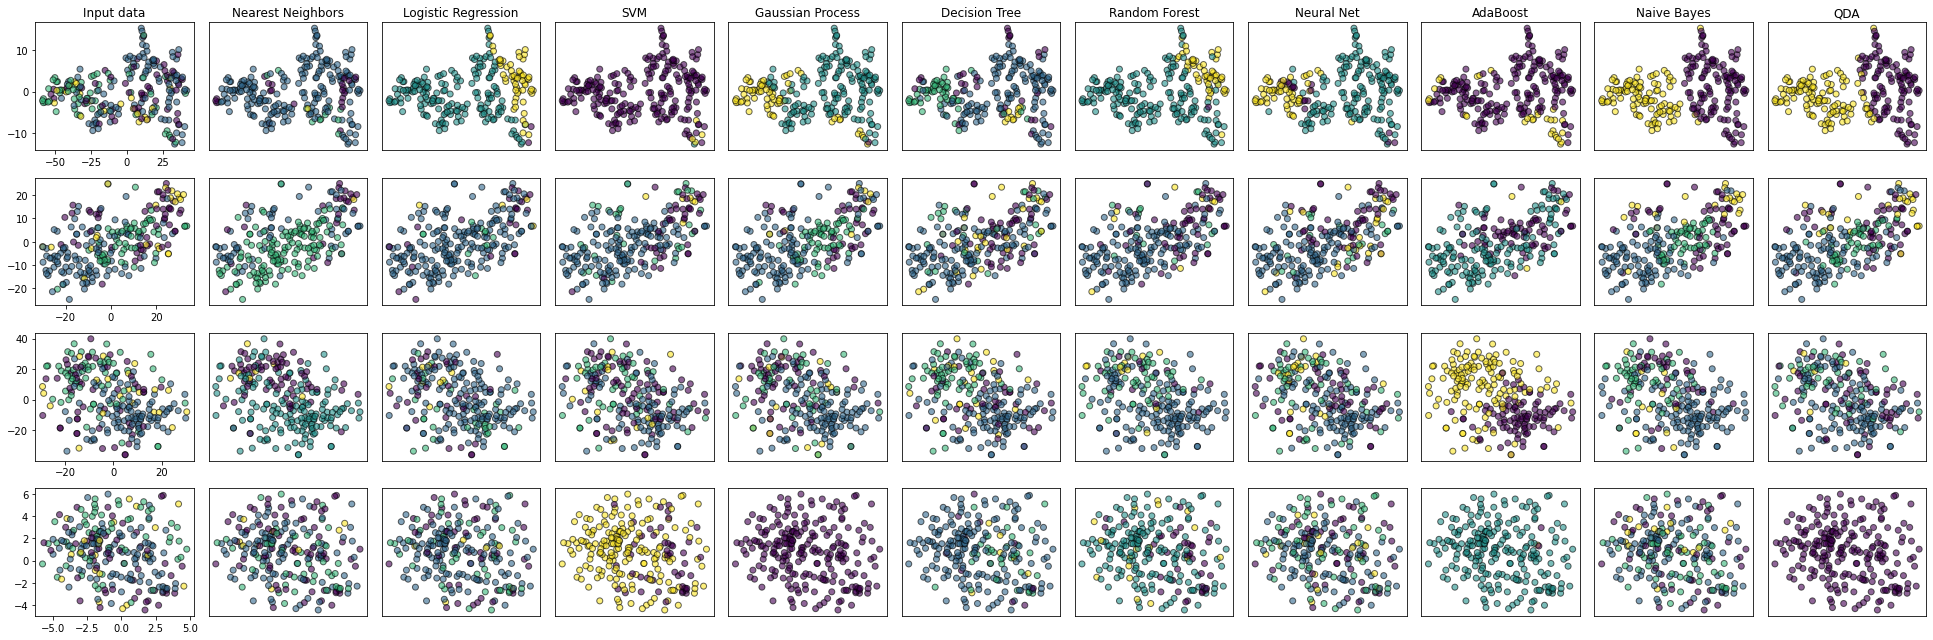

In [16]:
# Initialization
h = 0.02
metrics = {}
all_scores = []
all_times = []

figure = plt.figure(figsize=(27, 9))
im_count = 1

tsne = TSNE(n_components=2)

# Iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    
    # Preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
    n_train = X_train.shape[0]
    
    # Plot the train and test dataset in 2D using tSNE

    ax = plt.subplot(len(datasets), len(classifiers)+1, im_count)
    if ds_cnt == 0:
        ax.set_title("Input data")
    
    X_embedded = tsne.fit_transform(np.append(X_train,X_test,axis=0))
#     # Plot the training points
#     ax.scatter(X_embedded[:n_train, 0], X_embedded[:n_train, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(X_embedded[n_train:, 0], X_embedded[n_train:, 1], c=y_test, alpha=0.6, edgecolors='k')
    
    im_count += 1
    
    # Iterate over classifiers
    scores = []
    times = []
    
#     for name, clf in zip(classifier_names, classifiers):
    for name in classifier_names:
        print("Working on ",name)
        ax = plt.subplot(len(datasets), len(classifiers)+1 , im_count)
        
        # Find the best parameters for the classifier and dim. red. algorithm        
        best_params_path = 'Best_params/best_params_'+name+'_'+str(ds_cnt)+'.pkl'
        t0 = time.time()
        if os.path.exists(best_params_path):
#             with open(best_params_path) as fp:
#                 best_params = json.load(fp)
            best_params  = load(best_params_path)
            print("Loading from the existing file")
        else:
            print('here')
            best_params = tune_clf(X_train, y_train, [] , 5, name)
            dump(best_params,best_params_path)
#             with open(best_params_path, 'w') as fp:
#                 fp.write(json.dumps(best_params))
        print(best_params)
        
        # Apply dimensionality reduction to the dataset using the parameters from grid search CV
        X_train_dr = dim_red(X_train, y_train, best_params)
        X_test_dr = dim_red(X_test, y_test, best_params)
        
        # Get the paramaters for the classifier from 
        clf = best_params['classify']
        
        # Fit the classifier to the train dataset
        print("Train data shape ",X_train_dr.shape)
        print("Test data shape", X_test_dr.shape)
        
        clf.fit(X_train_dr, y_train)
        t1 = time.time()
        score = clf.score(X_test_dr, y_test)

        # Plot the predictions on the test dataset
        ax.scatter(X_embedded[n_train:, 0], X_embedded[n_train:, 1], c=clf.predict(X_test_dr),
                   edgecolors='k', alpha=0.6)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        im_count += 1
        
        # Compute metrics
        metrics[name]=calculate_precision_recall_f1score_support(clf.predict(X_test_dr),y_test)
        scores.append([name, score])
        times.append([name, (t1-t0)])
        
    all_scores.append(scores)
    all_times.append(times)
    
plt.tight_layout()
plt.show()

In [17]:
#%run classifiers_set2_1.ipynb

# Results

In [18]:
# !pip install termtables

In [19]:
# !pip install seaborn

In [20]:
# Including the results of CNN to scores and times

for i in all_scores:
    i.append(["CNN",0.6666])
    
# CNN training time: ~30 mins (on CPU)

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.42127659574468085 |
+---------------------+---------------------+
| Logistic Regression | 0.2978723404255319  |
+---------------------+---------------------+
| SVM                 | 0.4340425531914894  |
+---------------------+---------------------+
| Gaussian Process    | 0.574468085106383   |
+---------------------+---------------------+
| Decision Tree       | 0.4595744680851064  |
+---------------------+---------------------+
| Random Forest       | 0.2978723404255319  |
+---------------------+---------------------+
| Neural Net          | 0.5319148936170213  |
+---------------------+---------------------+
| AdaBoost            | 0.4765957446808511  |
+---------------------+---------------------+
| Naive Bayes         | 0.49361702127659574 |
+---------------------+---------------------+
| QDA                 | 0.48936170

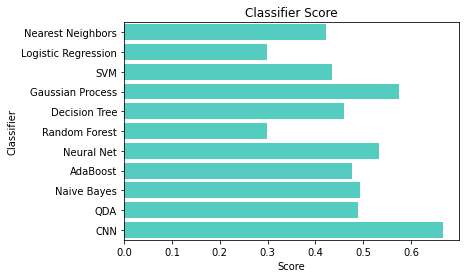

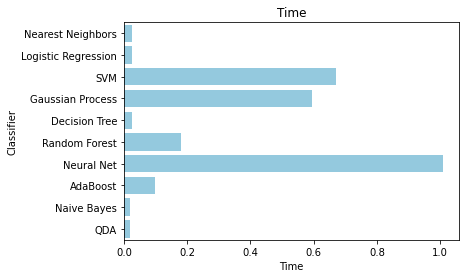

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.39574468085106385 |
+---------------------+---------------------+
| Logistic Regression | 0.4425531914893617  |
+---------------------+---------------------+
| SVM                 | 0.44680851063829785 |
+---------------------+---------------------+
| Gaussian Process    | 0.6510638297872341  |
+---------------------+---------------------+
| Decision Tree       | 0.37446808510638296 |
+---------------------+---------------------+
| Random Forest       | 0.4553191489361702  |
+---------------------+---------------------+
| Neural Net          | 0.43829787234042555 |
+---------------------+---------------------+
| AdaBoost            | 0.41702127659574467 |
+---------------------+---------------------+
| Naive Bayes         | 0.6595744680851063  |
+---------------------+---------------------+
| QDA                 | 0.58297872

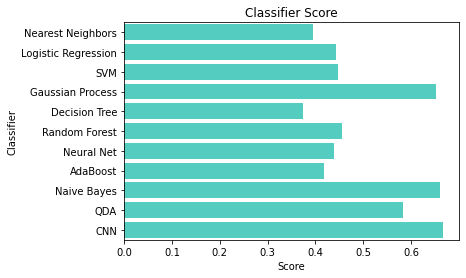

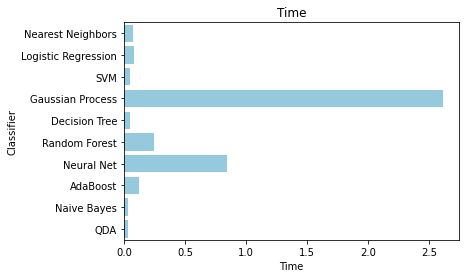

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.43829787234042555 |
+---------------------+---------------------+
| Logistic Regression | 0.42127659574468085 |
+---------------------+---------------------+
| SVM                 | 0.34893617021276596 |
+---------------------+---------------------+
| Gaussian Process    | 0.5404255319148936  |
+---------------------+---------------------+
| Decision Tree       | 0.43829787234042555 |
+---------------------+---------------------+
| Random Forest       | 0.4765957446808511  |
+---------------------+---------------------+
| Neural Net          | 0.35319148936170214 |
+---------------------+---------------------+
| AdaBoost            | 0.5361702127659574  |
+---------------------+---------------------+
| Naive Bayes         | 0.502127659574468   |
+---------------------+---------------------+
| QDA                 | 0.41702127

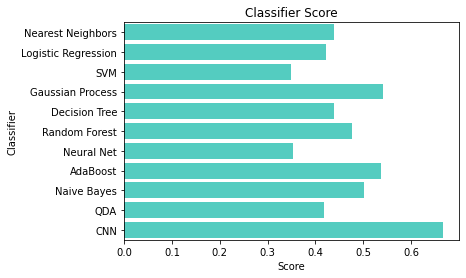

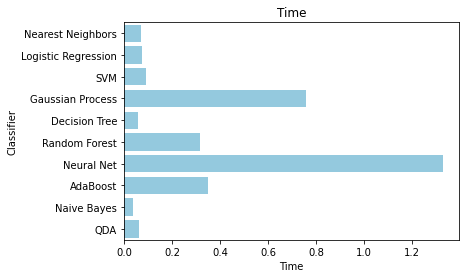

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.2978723404255319  |
+---------------------+---------------------+
| Logistic Regression | 0.37872340425531914 |
+---------------------+---------------------+
| SVM                 | 0.3702127659574468  |
+---------------------+---------------------+
| Gaussian Process    | 0.4425531914893617  |
+---------------------+---------------------+
| Decision Tree       | 0.3574468085106383  |
+---------------------+---------------------+
| Random Forest       | 0.40425531914893614 |
+---------------------+---------------------+
| Neural Net          | 0.37446808510638296 |
+---------------------+---------------------+
| AdaBoost            | 0.4340425531914894  |
+---------------------+---------------------+
| Naive Bayes         | 0.28936170212765955 |
+---------------------+---------------------+
| QDA                 | 0.44255319

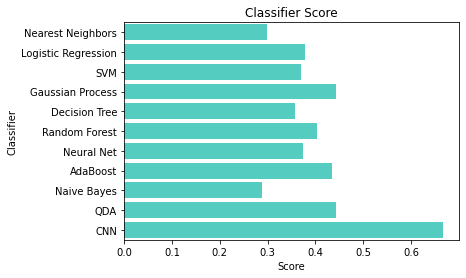

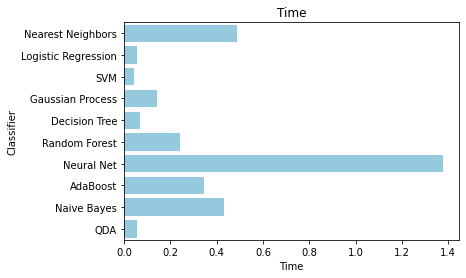

+---------------------+----------------------+
| Classifier          | Time                 |
+=====================+======================+
| Nearest Neighbors   | 0.4889991283416748   |
+---------------------+----------------------+
| Logistic Regression | 0.0540013313293457   |
+---------------------+----------------------+
| SVM                 | 0.043998003005981445 |
+---------------------+----------------------+
| Gaussian Process    | 0.1430065631866455   |
+---------------------+----------------------+
| Decision Tree       | 0.06800031661987305  |
+---------------------+----------------------+
| Random Forest       | 0.242020845413208    |
+---------------------+----------------------+
| Neural Net          | 1.3770029544830322   |
+---------------------+----------------------+
| AdaBoost            | 0.3459935188293457   |
+---------------------+----------------------+
| Naive Bayes         | 0.4309828281402588   |
+---------------------+----------------------+
| QDA        

In [21]:
import termtables as tt
import seaborn as sns

for i,d in enumerate(datasets):
    # Classifier scores -
    # Table
    string = tt.to_string(
        all_scores[i],
        header=["Classifier", "Score"],
        style=tt.styles.ascii_thin_double,
        # alignment="ll",
        # padding=(0, 1),
    )
    print(string)
    
    # Histogram
    log = pd.DataFrame(all_scores[i], columns=["Classifier", "Score"])
#     print(log)
    sns.set_color_codes("pastel")
    sns.barplot(x='Score', y='Classifier', data=log, color = 'turquoise')

    plt.xlabel('Score')
    plt.title('Classifier Score')
    plt.show()
    

    string = tt.to_string(
        all_times[i],
        header=["Classifier", "Time"], #Check this!
        style=tt.styles.ascii_thin_double,
        # alignment="ll",
        # padding=(0, 1),
    )
    
    log = pd.DataFrame(all_times[i], columns=["Classifier", "Time"])
    sns.set_color_codes("pastel")
    sns.barplot(x='Time', y='Classifier', data=log, color = 'skyblue')

    plt.xlabel('Time')
    plt.title('Time')
    plt.show()
    
    
print(string)

measure = ["precision", "recall", "fbeta_score", "support"]
print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format('Classifier','Diego', 'Rembrandt', 'Peter', 'Caravaggio'))
for k, v in metrics.items():
 
    for i in range(4):
        
        print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format(k,v[i][0],v[i][1],v[i][2],v[i][3]))

# New Dataset

In [22]:
image_vectors_part_1_list_tuple = pd.read_pickle( "Feature Extraction/New Image Vectors - Part 1.pkl")
image_vectors_part_2_list_tuple = pd.read_pickle( "Feature Extraction/New Image Vectors - Part 2.pkl")
image_vectors_part_3_list_tuple = pd.read_pickle( "Feature Extraction/New Image Vectors - Part 3.pkl")
image_vectors_part_4_list_tuple = pd.read_pickle( "Feature Extraction/New Image Vectors - Part 4.pkl")
hu_moments_list_tuple = pd.read_pickle( "Feature Extraction/New Hu Moments.pkl") 
histograms_list_tuple = pd.read_pickle( "Feature Extraction/New Color Hists.pkl" ) 
hog_list_tuple = pd.read_pickle( "Feature Extraction/New Hogs.pkl") 
lbp_list_tuple = pd.read_pickle( "Feature Extraction/New LBPs.pkl" ) 
sift_list_tuple = pd.read_pickle( "Feature Extraction/New SIFTs.pkl" ) 

(908, 1214, 3)


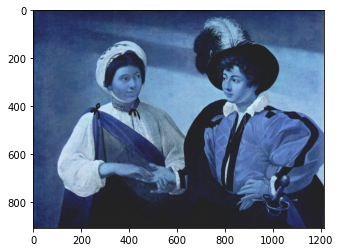

(2700,)


In [23]:
import cv2
im = [x[2] for x in image_vectors_part_1_list_tuple][1]
print(im.shape)
plt.imshow(im)
plt.show()
dim = (30,30)
resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA).reshape(2700)
print(resized.shape)

images_vector = []
for i in [x[2] for x in image_vectors_part_1_list_tuple]:
    images_vector.append(cv2.resize(im, dim, interpolation = cv2.INTER_AREA).reshape(2700))
    

for i in [x[2] for x in image_vectors_part_2_list_tuple]:
    images_vector.append(cv2.resize(im, dim, interpolation = cv2.INTER_AREA).reshape(2700))
    

for i in [x[2] for x in image_vectors_part_3_list_tuple]:
    images_vector.append(cv2.resize(im, dim, interpolation = cv2.INTER_AREA).reshape(2700))
    

for i in [x[2] for x in image_vectors_part_4_list_tuple]:
    images_vector.append(cv2.resize(im, dim, interpolation = cv2.INTER_AREA).reshape(2700))
    
images_vector = np.array(images_vector)  



In [24]:
print("(Number of images, Number of features)")
print("Images vector:",images_vector.shape)

(Number of images, Number of features)
Images vector: (2204, 2700)


In [25]:
type([x[1] for x in histograms_list_tuple])
names = [x[1] for x in histograms_list_tuple]
d = {ni: indi for indi, ni in enumerate(set(names))}
y = np.array([d[ni] for ni in names])

In [26]:
hu_moments = np.squeeze(np.array([x[2] for x in hu_moments_list_tuple]))
histograms = np.reshape(np.squeeze(np.array([x[2] for x in histograms_list_tuple])),(len(hu_moments_list_tuple),-1))
hog = np.squeeze(np.array([x[2] for x in hog_list_tuple]))
lbp = np.reshape(np.squeeze(np.array([x[2] for x in lbp_list_tuple])),(len(hu_moments_list_tuple),-1))
sift = np.squeeze([i[:20,:] for i in [x[2] for x in sift_list_tuple]]).reshape(-1,2560)

# Feature dimensions
print("(Number of images, Number of features)")
print("Hu Moments:",hu_moments.shape)
print("Histograms:",histograms.shape)
print("HoG:",hog.shape)
print("LBP:",lbp.shape)
print("SIFT:",sift.shape)

(Number of images, Number of features)
Hu Moments: (2204, 7)
Histograms: (2204, 768)
HoG: (2204, 3600)
LBP: (2204, 40000)
SIFT: (2204, 2560)


In [27]:
datasets = [
            (hu_moments,y),
            (histograms,y),
            (hog,y),
            (lbp,y),
            (sift,y),
            (images_vector,y)]
features_names = [
    "Hu Moments",
    "Histograms",
    "HoG",
    "LBP",
    "SIFT",
    "Images_vector"
    
]

In [28]:
'Best_params/best_params_'+classifier_names[1]+'_'+features_names[1]+'.pkl'

'Best_params/best_params_Logistic Regression_Histograms.pkl'

Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=6), 'classify__n_neighbors': 8, 'classify': KNeighborsClassifier(n_neighbors=8)}
Train data shape  (1322, 6)
Test data shape (882, 6)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 4, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=4), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (1322, 4)
Test data shape (882, 4)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  SVM
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify__kernel': 'poly', 'classify__gamma': 10, 'classify__C': 0.1, 'classify': SVC(C=0.1, gamma=10, kernel='poly', max_iter=100000)}
Train data shape  (1322, 3)
Test data shape (882, 3)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Gaussian Process
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': GaussianProcessClassifier()}
Train data shape  (1322, 3)
Test data shape (882, 3)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 2, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=2), 'classify__splitter': 'random', 'classify__max_depth': 5, 'classify__criterion': 'gini', 'classify': DecisionTreeClassifier(max_depth=5, splitter='random')}
Train data shape  (1322, 2)
Test data shape (882, 2)
Working on  Random Forest
Loading from the existing file
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=6), 'classify__max_depth': 5, 'classify__criterion': 'gini', 'classify': RandomForestClassifier(max_depth=5)}
Train data shape  (1322, 6)
Test data shape (882, 6)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Neural Net
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify__hidden_layer_sizes': (100, 50, 20), 'classify__alpha': 0.01, 'classify': MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50, 20))}
Train data shape  (1322, 3)
Test data shape (882, 3)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 6, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=6), 'classify__learning_rate': 0.1, 'classify': AdaBoostClassifier(learning_rate=0.1)}
Train data shape  (1322, 6)
Test data shape (882, 6)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 2, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=2), 'classify': GaussianNB()}
Train data shape  (1322, 2)
Test data shape (882, 2)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 2, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=2), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (1322, 2)
Test data shape (882, 2)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=200), 'classify__n_neighbors': 7, 'classify': KNeighborsClassifier(n_neighbors=7)}
Train data shape  (1322, 200)
Test data shape (882, 200)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (1322, 100)
Test data shape (882, 100)
Working on  SVM
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=100), 'classify__kernel': 'poly', 'classify__gamma': 10, 'classify__C': 0.05, 'classify': SVC(C=0.05, gamma=10, kernel='poly', max_iter=100000)}
Train data shape  (1322, 100)
Test data shape (882, 100)
Working on  Gaussian Process
Loading from t

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__splitter': 'best', 'classify__max_depth': 10, 'classify__criterion': 'entropy', 'classify': DecisionTreeClassifier(criterion='entropy', max_depth=10)}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Random Forest
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__max_depth': 10, 'classify__criterion': 'entropy', 'classify': RandomForestClassifier(criterion='entropy', max_depth=10)}
Train data shape  (1322, 100)
Test data shape (882, 100)
Working on  Neural Net
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__hidden_layer_sizes': (100, 20, 10), 'classify__alpha': 0.01, 'classify': MLPCla

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=10), 'classify__learning_rate': 0.1, 'classify': AdaBoostClassifier(learning_rate=0.1)}
Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': GaussianNB()}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__n_neighbors': 7, 'classify': KNeighborsClassifier(n_neighbors=7)}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=20

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 500, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=500), 'classify__learning_rate': 0.1, 'classify': AdaBoostClassifier(learning_rate=0.1)}
Train data shape  (1322, 500)
Test data shape (882, 500)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': GaussianNB()}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=100), 'classify__n_neighbors': 5, 'classify': KNeighborsClassifier()}
Train data shape  (1322, 100)
Test data shape (882, 100)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Working on  Gaussian Process
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': GaussianProcessClassifier()}
Train data shape  (1322, 3)
Test data shape (882, 3)
Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__splitter': 'best', 'classify__max_depth': 15, 'classify__criterion': 'gini', 'classify': DecisionTreeClassifier(max_depth=15)}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Random Forest
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify__max_depth': 15, 'classify__criterion': 'entropy', 'classify': RandomForestClassifier(criterion='entropy', max_depth=15)}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Neural Net
Loading from the existing file
{'reduce_dim__

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify__learning_rate': 0.01, 'classify': AdaBoostClassifier(learning_rate=0.01)}
Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': GaussianNB()}
Train data shape  (1322, 3)
Test data shape (882, 3)
Working on  QDA
Loading from the existing file
{'reduce_dim': LinearDiscriminantAnalysis(n_components=3), 'classify': QuadraticDiscriminantAnalysis()}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train data shape  (1322, 3)
Test data shape (882, 3)
Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=100), 'classify__n_neighbors': 8, 'classify': KNeighborsClassifier(n_neighbors=8)}
Train data shape  (1322, 100)
Test data shape (882, 100)
Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=10), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  SVM
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=10), 'classify__kernel': 'linear', 'classify__gamma': 1, 'classify__C': 1, 'classify': SVC(C=1, gamma=1, kernel='linear', max_iter=100000)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Gaussian Process
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=10), 'classify': GaussianProcessClassifier()}
Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__splitter': 'best', 'classify__max_depth': 5, 'classify__criterion': 'entropy', 'classify': DecisionTreeClassifier(criterion='entropy', max_depth=5)}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Random Forest
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify__max_depth': 10, 'classify__criterion': 'gini', 'classify': RandomForestClassifier(max_depth=10)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Neural Net
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify__hidden_layer_sizes': (100, 20, 10), 'classify__alpha': 1.0, 'classify': MLPClassifier(alpha=1.0, hidden_layer_sizes=(100, 20, 10))}
Train data shape 

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 (1322, 10)
Test data shape (882, 10)
Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify__learning_rate': 0.1, 'classify': AdaBoostClassifier(learning_rate=0.1)}
Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify': GaussianNB()}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=10), 'classify': QuadraticDiscriminantAnalysis()}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Nearest Neighbors
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=200), 'classify__n_neighbors': 8, 'classify': KNeighborsClassifier(n_neighbors=8)}
Train data shape  (1322, 200)
Test data shape (882, 200)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Logistic Regression
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=200), 'classify': LogisticRegression(max_iter=10000)}
Train data shape  (1322, 200)
Test data shape (882, 200)
Working on  SVM
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'poly', 'reduce_dim': KernelPCA(kernel='poly', n_components=10), 'classify__kernel': 'rbf', 'classify__gamma': 1, 'classify__C': 0.025, 'classify': SVC(C=0.025, gamma=1, max_iter=100000)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Gaussian Process
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify': GaussianProcessClassifier()}
Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Decision Tree
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__splitter': 'best', 'classify__max_depth': 5, 'classify__criterion': 'entropy', 'classify': DecisionTreeClassifier(criterion='entropy', max_depth=5)}
Train data shape  (1322, 10)
Test data shape (882, 10)
Working on  Random Forest
Loading from the existing file
{'reduce_dim__n_components': 10, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=10), 'classify__max_depth': 5, 'classify__criterion': 'gini', 'classify': RandomForestClassifier(max_depth=5)}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train data shape  (1322, 10)
Test data shape (882, 10)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Neural Net
Loading from the existing file
{'reduce_dim__n_components': 100, 'reduce_dim__kernel': 'linear', 'reduce_dim': KernelPCA(n_components=100), 'classify__hidden_layer_sizes': (100, 100, 20), 'classify__alpha': 0.01, 'classify': MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 100, 20))}
Train data shape  (1322, 100)
Test data shape (882, 100)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  AdaBoost
Loading from the existing file
{'reduce_dim__n_components': 200, 'reduce_dim__kernel': 'rbf', 'reduce_dim': KernelPCA(kernel='rbf', n_components=200), 'classify__learning_rate': 0.01, 'classify': AdaBoostClassifier(learning_rate=0.01)}
Train data shape  (1322, 200)
Test data shape (882, 200)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on  Naive Bayes
Loading from the existing file
{'reduce_dim__n_components': 3, 'reduce_dim': tSNE(n_components=3), 'classify': GaussianNB()}
Train data shape  (1322, 2)
Test data shape (882, 2)
Working on  QDA
Loading from the existing file
{'reduce_dim__n_components': 2, 'reduce_dim': tSNE(), 'classify': QuadraticDiscriminantAnalysis()}


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train data shape  (1322, 2)
Test data shape (882, 2)


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


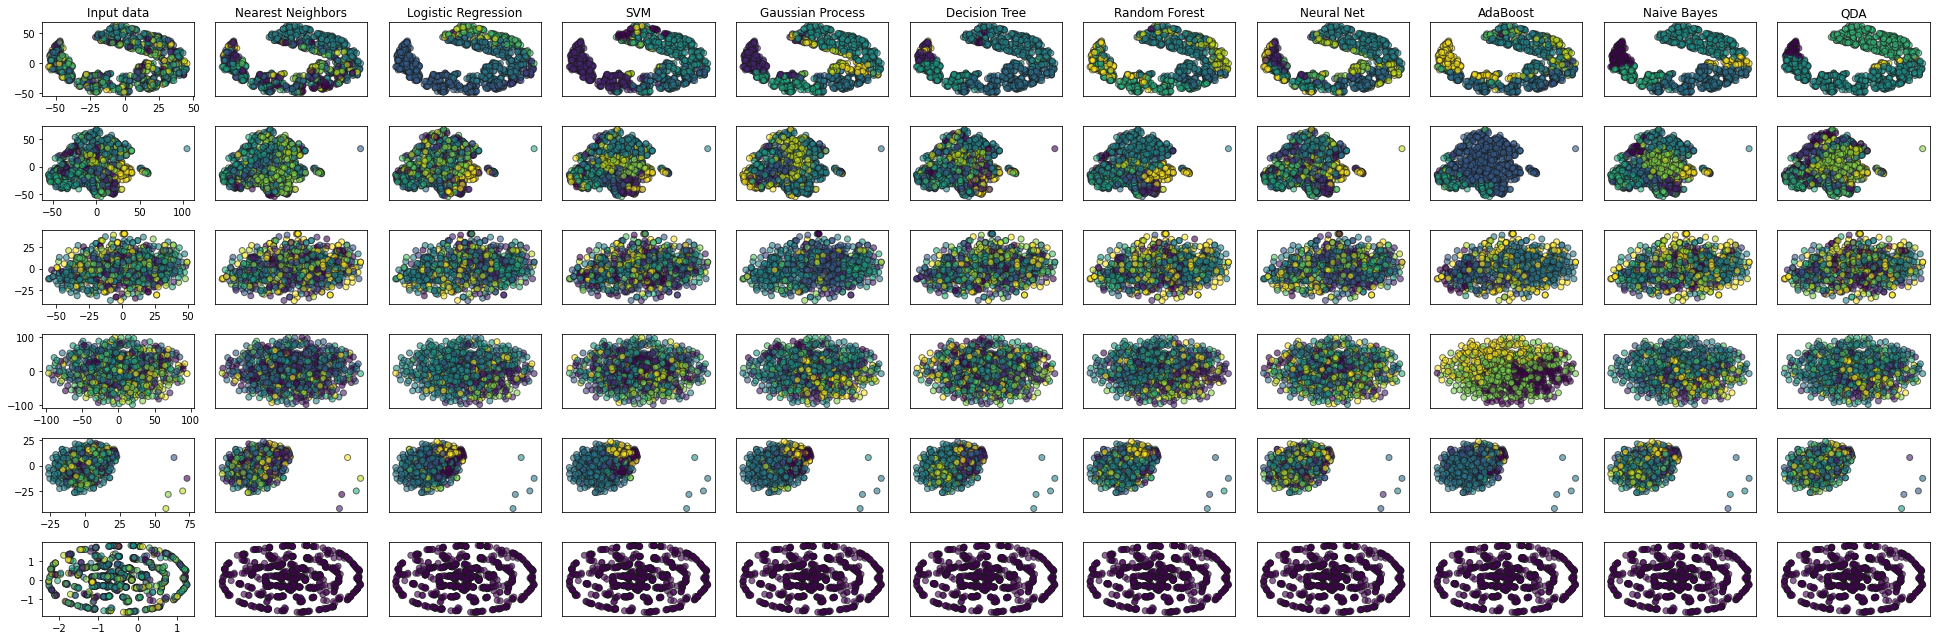

In [29]:
# Initialization
h = 0.02
metrics = {}
all_scores = []
all_times = []

figure = plt.figure(figsize=(27, 9))
im_count = 1
tsne = TSNE(n_components=2)

# Iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    
    # Preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
    n_train = X_train.shape[0]
    
    # Plot the train and test dataset in 2D using tSNE

    ax = plt.subplot(len(datasets), len(classifiers)+1, im_count)
    if ds_cnt == 0:
        ax.set_title("Input data")
    
    X_embedded = tsne.fit_transform(np.append(X_train,X_test,axis=0))
#     # Plot the training points
#     ax.scatter(X_embedded[:n_train, 0], X_embedded[:n_train, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(X_embedded[n_train:, 0], X_embedded[n_train:, 1], c=y_test, alpha=0.6, edgecolors='k')
    
    im_count += 1
    
    # Iterate over classifiers
    scores = []
    times = []
    
#     for name, clf in zip(classifier_names, classifiers):
    for name in classifier_names:
        print("Working on ",name)
        ax = plt.subplot(len(datasets), len(classifiers)+1 , im_count)
        
        # Find the best parameters for the classifier and dim. red. algorithm        
        best_params_path = 'Best_params/best_params_'+name+'_'+features_names[ds_cnt]+'.pkl'
        t0 = time.time()
        if os.path.exists(best_params_path):
            best_params  = load(best_params_path)
            print("Loading from the existing file")
        else:
            print('here')
            best_params = tune_clf(X_train, y_train, [] , 5, name)
            dump(best_params,best_params_path)
        print(best_params)
        
        # Apply dimensionality reduction to the dataset using the parameters from grid search CV
        X_train_dr = dim_red(X_train, y_train, best_params)
        X_test_dr = dim_red(X_test, y_test, best_params)
        
        # Get the paramaters for the classifier from 
        clf = best_params['classify']
        
        # Fit the classifier to the train dataset
        print("Train data shape ",X_train_dr.shape)
        print("Test data shape", X_test_dr.shape)
        
        clf.fit(X_train_dr, y_train)
        t1 = time.time()
        score = clf.score(X_test_dr, y_test)

        # Plot the predictions on the test dataset
        ax.scatter(X_embedded[n_train:, 0], X_embedded[n_train:, 1], c=clf.predict(X_test_dr),
                   edgecolors='k', alpha=0.6)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        im_count += 1
        
        # Compute metrics
        metrics[name]=calculate_precision_recall_f1score_support(clf.predict(X_test_dr),y_test)
        scores.append([name, score])
        times.append([name, (t1-t0)])
        
    all_scores.append(scores)
    all_times.append(times)

    
plt.tight_layout()
plt.show()

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.2732426303854875  |
+---------------------+---------------------+
| Logistic Regression | 0.12698412698412698 |
+---------------------+---------------------+
| SVM                 | 0.22789115646258504 |
+---------------------+---------------------+
| Gaussian Process    | 0.30158730158730157 |
+---------------------+---------------------+
| Decision Tree       | 0.2811791383219955  |
+---------------------+---------------------+
| Random Forest       | 0.19727891156462585 |
+---------------------+---------------------+
| Neural Net          | 0.31746031746031744 |
+---------------------+---------------------+
| AdaBoost            | 0.17346938775510204 |
+---------------------+---------------------+
| Naive Bayes         | 0.2789115646258503  |
+---------------------+---------------------+
| QDA                 | 0.26530612

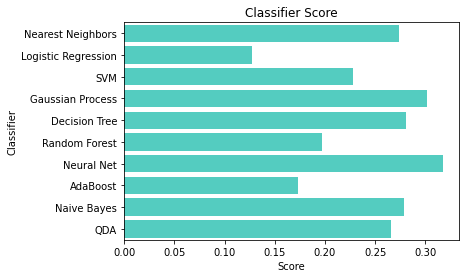

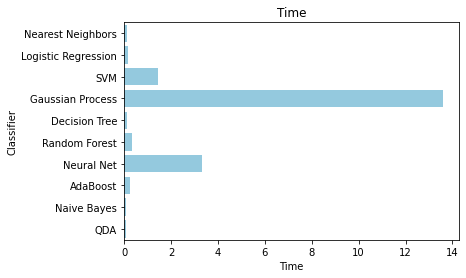

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.1417233560090703  |
+---------------------+---------------------+
| Logistic Regression | 0.29931972789115646 |
+---------------------+---------------------+
| SVM                 | 0.4070294784580499  |
+---------------------+---------------------+
| Gaussian Process    | 0.14285714285714285 |
+---------------------+---------------------+
| Decision Tree       | 0.3197278911564626  |
+---------------------+---------------------+
| Random Forest       | 0.4217687074829932  |
+---------------------+---------------------+
| Neural Net          | 0.3197278911564626  |
+---------------------+---------------------+
| AdaBoost            | 0.23582766439909297 |
+---------------------+---------------------+
| Naive Bayes         | 0.3832199546485261  |
+---------------------+---------------------+
| QDA                 | 0.26303854

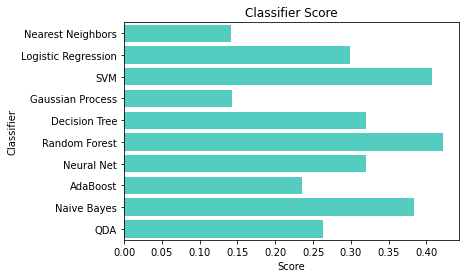

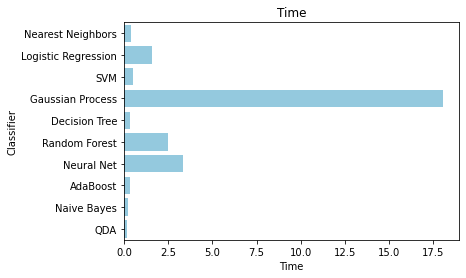

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.10204081632653061 |
+---------------------+---------------------+
| Logistic Regression | 0.20521541950113378 |
+---------------------+---------------------+
| SVM                 | 0.17913832199546487 |
+---------------------+---------------------+
| Gaussian Process    | 0.22675736961451248 |
+---------------------+---------------------+
| Decision Tree       | 0.08049886621315193 |
+---------------------+---------------------+
| Random Forest       | 0.11224489795918367 |
+---------------------+---------------------+
| Neural Net          | 0.15192743764172337 |
+---------------------+---------------------+
| AdaBoost            | 0.10090702947845805 |
+---------------------+---------------------+
| Naive Bayes         | 0.15532879818594103 |
+---------------------+---------------------+
| QDA                 | 0.12244897

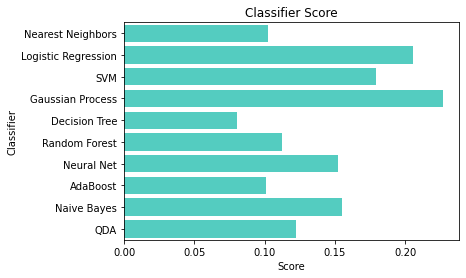

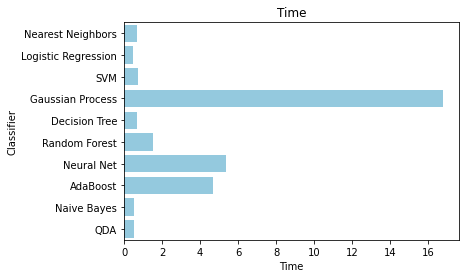

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.1349206349206349  |
+---------------------+---------------------+
| Logistic Regression | 0.2743764172335601  |
+---------------------+---------------------+
| SVM                 | 0.15759637188208617 |
+---------------------+---------------------+
| Gaussian Process    | 0.13945578231292516 |
+---------------------+---------------------+
| Decision Tree       | 0.1836734693877551  |
+---------------------+---------------------+
| Random Forest       | 0.2743764172335601  |
+---------------------+---------------------+
| Neural Net          | 0.15532879818594103 |
+---------------------+---------------------+
| AdaBoost            | 0.2698412698412698  |
+---------------------+---------------------+
| Naive Bayes         | 0.1145124716553288  |
+---------------------+---------------------+
| QDA                 | 0.12131519

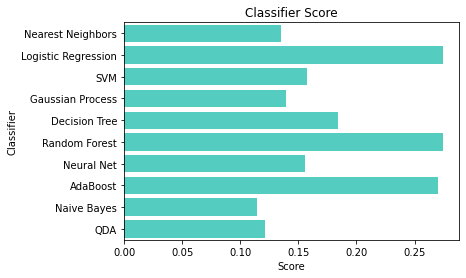

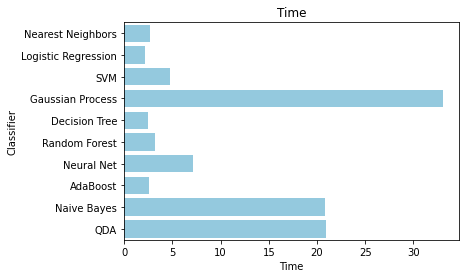

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.16439909297052155 |
+---------------------+---------------------+
| Logistic Regression | 0.2528344671201814  |
+---------------------+---------------------+
| SVM                 | 0.2619047619047619  |
+---------------------+---------------------+
| Gaussian Process    | 0.25963718820861675 |
+---------------------+---------------------+
| Decision Tree       | 0.2437641723356009  |
+---------------------+---------------------+
| Random Forest       | 0.14965986394557823 |
+---------------------+---------------------+
| Neural Net          | 0.12811791383219956 |
+---------------------+---------------------+
| AdaBoost            | 0.16666666666666666 |
+---------------------+---------------------+
| Naive Bayes         | 0.15873015873015872 |
+---------------------+---------------------+
| QDA                 | 0.15873015

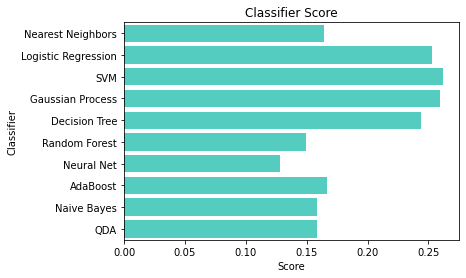

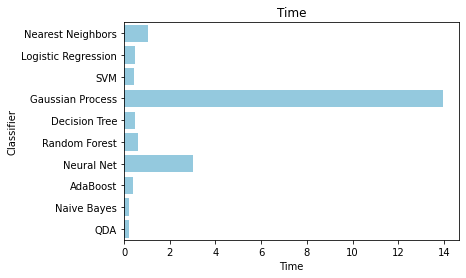

+---------------------+---------------------+
| Classifier          | Score               |
+=====================+=====================+
| Nearest Neighbors   | 0.08616780045351474 |
+---------------------+---------------------+
| Logistic Regression | 0.1927437641723356  |
+---------------------+---------------------+
| SVM                 | 0.1927437641723356  |
+---------------------+---------------------+
| Gaussian Process    | 0.1927437641723356  |
+---------------------+---------------------+
| Decision Tree       | 0.1927437641723356  |
+---------------------+---------------------+
| Random Forest       | 0.1927437641723356  |
+---------------------+---------------------+
| Neural Net          | 0.1927437641723356  |
+---------------------+---------------------+
| AdaBoost            | 0.1927437641723356  |
+---------------------+---------------------+
| Naive Bayes         | 0.1927437641723356  |
+---------------------+---------------------+
| QDA                 | 0.19274376

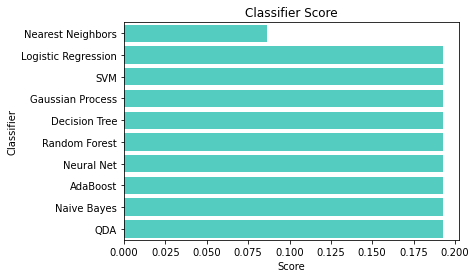

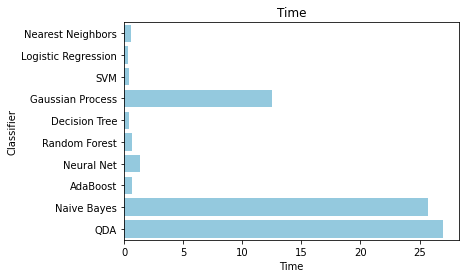

+---------------------+---------------------+
| Classifier          | Time                |
+=====================+=====================+
| Nearest Neighbors   | 0.5480027198791504  |
+---------------------+---------------------+
| Logistic Regression | 0.35700345039367676 |
+---------------------+---------------------+
| SVM                 | 0.42999744415283203 |
+---------------------+---------------------+
| Gaussian Process    | 12.547999143600464  |
+---------------------+---------------------+
| Decision Tree       | 0.42400264739990234 |
+---------------------+---------------------+
| Random Forest       | 0.6419956684112549  |
+---------------------+---------------------+
| Neural Net          | 1.3709619045257568  |
+---------------------+---------------------+
| AdaBoost            | 0.7080023288726807  |
+---------------------+---------------------+
| Naive Bayes         | 25.70400094985962   |
+---------------------+---------------------+
| QDA                 | 26.9792928

In [31]:
import termtables as tt
import seaborn as sns

for i,d in enumerate(datasets):
    # Classifier scores -
    # Table
    string = tt.to_string(
        all_scores[i],
        header=["Classifier", "Score"],
        style=tt.styles.ascii_thin_double,
        # alignment="ll",
        # padding=(0, 1),
    )
    print(string)
    
    # Histogram
    log = pd.DataFrame(all_scores[i], columns=["Classifier", "Score"])
#     print(log)
    sns.set_color_codes("pastel")
    sns.barplot(x='Score', y='Classifier', data=log, color = 'turquoise')

    plt.xlabel('Score')
    plt.title('Classifier Score')
    plt.show()
    

    string = tt.to_string(
        all_times[i],
        header=["Classifier", "Time"], #Check this!
        style=tt.styles.ascii_thin_double,
        # alignment="ll",
        # padding=(0, 1),
    )
    
    log = pd.DataFrame(all_times[i], columns=["Classifier", "Time"])
    sns.set_color_codes("pastel")
    sns.barplot(x='Time', y='Classifier', data=log, color = 'skyblue')

    plt.xlabel('Time')
    plt.title('Time')
    plt.show()
    
    
print(string)

measure = ["precision", "recall", "fbeta_score", "support"]
print ("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format('Classifier','1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
for k, v in metrics.items():
 
    for i in range(4):
        
        print ("{:<20} {:<20} {:<20} {:<20} {:<20} ".format(k,v[i][0],v[i][1],v[i][2],v[i][3]))